In [2]:
from support_functions import *
%matplotlib inline

# Read and proces wav files
### Clean guitar

In [3]:
wav_player('data/clean_guitar.wav')

### Processed to chorus

<AxesSubplot:>

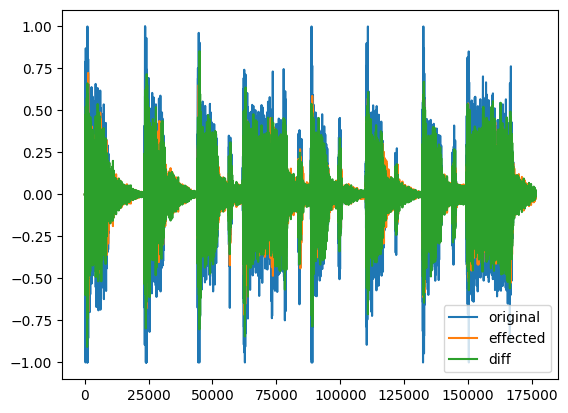

In [4]:
from pedalboard import Chorus, Reverb, Distortion

chorus = read_proces_dump('data/clean_guitar.wav', 
                 'data/chorus_guitar.wav', 
                 [Chorus(), Reverb(room_size=0.25)])

wav_player('data/chorus_guitar.wav')
chorus.plot()

### Processed to distortion

<AxesSubplot:>

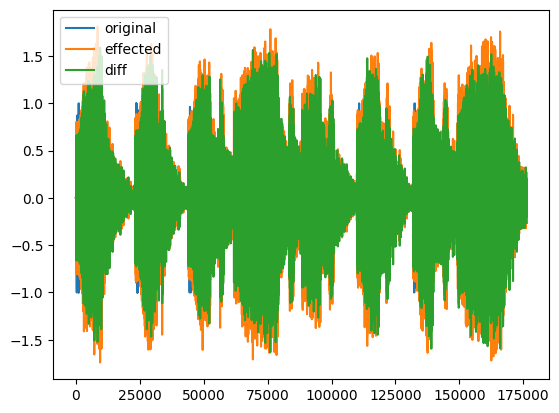

In [5]:
dist = read_proces_dump('data/clean_guitar.wav', 
                 'data/distortion_guitar.wav', 
                 [Distortion(), Reverb(room_size=0.25)])
wav_player('data/distortion_guitar.wav')
dist.plot()

# Preparing the data for keras
If need to package the data for use in a neural network. Because we want to let the neural network recreate the processing effects (chorus, distortion, etc), both the input and the output should be the audio clip. This makes me feels that I can't input the entire audio clip into a layer, but cut up the wav file into managable chunks. The chunk size is something to optimize. 

Luckily, the `read_proces_dump` function already returns both the input and the output wav files as a numpy array. Note that we resize to a chunk size of 512, and cut off the last little bit of the audio sample to get all multiples of 512:

In [6]:
chunk_size = 128    # <--- No real reason to choose 1024, no sensitivity study done
wav_length = len(dist)
max_multiple = wav_length - (wav_length % chunk_size)
original_chunked = dist['original'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))   
effected_chunked = dist['effected'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))
print(original_chunked.shape)
print(effected_chunked.shape)


(1378, 128, 1)
(1378, 128, 1)


So this gives us 344 chunks of audio, each with 512 samples. 

# Building a model that can reproduce the distortion
The setup I'm thinking about right now is to create an encoder-decoder network which takes in the input audio, and spits out the output audio. The following is heavily inspired by a group of students I supervised:

In [7]:
from keras import Sequential, Model
import keras.layers as layers
import tensorflow as tf

kernel_size=3  # <---- started with 3, from a https://github.com/GuitarML/GuitarLSTM/blob/main/train.py tried 12, but this lead to massive
               #       overfitting

# Have not really played around with the layers, this 
# architecture is something roughly copied from a paper about
# selfsupervised learning 
model = Sequential(
    [
        layers.Conv1D(32, kernel_size=kernel_size, input_shape=(chunk_size,1), padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.MaxPooling1D(),

        layers.Conv1D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.MaxPooling1D(),
        
        layers.Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.MaxPooling1D(),

        layers.Conv1DTranspose(128, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
        layers.Conv1DTranspose(64, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
        layers.Conv1DTranspose(32, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
        layers.Conv1D(1, kernel_size=kernel_size, padding='same', activation='linear') # <---- needs to be linear and not relu to be able to generate negative numbers
    ]
)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)   # <---- Needs to be rather low to actually learn anything
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 32)           0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 64, 64)            6208      
                                                                 
 conv1d_4 (Conv1D)           (None, 64, 64)            12352     
                                                        

Our first step is to simply predict using the untrained model, this obviously will not really yield us any good results, but allow us to develop the tools and test what happens. First we just take one chunk, note we heavily resize to fit what this keras model wants `(1, chunk_size, 1)` if we just pass one example to predict on:

In [8]:
import numpy as np

untrained_prediction = model.predict(np.resize(original_chunked[:,2], (1, chunk_size, 1)))
untrained_prediction.shape

1/1 [==============================] - 4s 4s/step


(1, 128, 1)

Now we can process an entire audio clip and listen to the result of the untrained model. To process the entire audio clip we take the chunked data:

44/44 [==============================] - 0s 7ms/step


<AxesSubplot:>

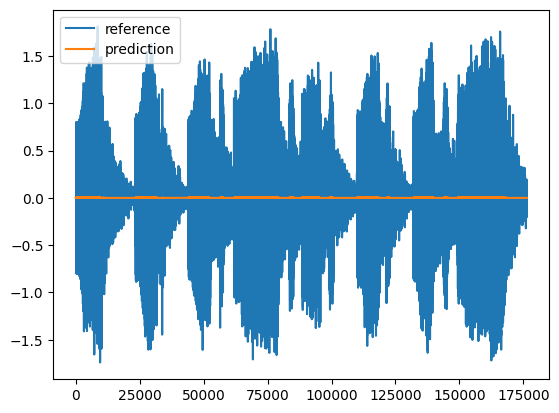

In [9]:
untrained_entire_clip = model.predict(np.resize(original_chunked, (original_chunked.size // chunk_size, chunk_size, 1)))
untrained_flat = untrained_entire_clip.flatten()
pd.DataFrame({'reference': dist['effected'][0:len(untrained_flat)], 'prediction': untrained_flat}).plot()

In [10]:
dump_numpy_audio(resize_to_mono(untrained_entire_clip),
                 reference_wav='data/clean_guitar.wav',
                 output_wav='data/untrained_distortion_guitar.wav')

This actually does not produce any audible sound. If you however dump `original_chunked` in the same way, you get the correct audio clip back, which indicates the function should work once we train the model. 

# Train the model
We now train the model with the chopped up one audio clip. 

In [11]:
from sklearn.model_selection import train_test_split

original_train, original_test, effected_train, effected_test = train_test_split(original_chunked, effected_chunked, test_size=0.2)
print(original_train.shape)
print(effected_train.shape)
print(original_test.shape)
print(effected_test.shape)

(1102, 128, 1)
(1102, 128, 1)
(276, 128, 1)
(276, 128, 1)


In [12]:
history = model.fit(original_train, effected_train, epochs=40, batch_size=4, validation_data=(original_test, effected_test))

Epoch 1/40
276/276 [==============================] - 5s 11ms/step - loss: 0.1737 - val_loss: 0.1005
Epoch 2/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0891 - val_loss: 0.0793
Epoch 3/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0749 - val_loss: 0.0689
Epoch 4/40
276/276 [==============================] - 2s 7ms/step - loss: 0.0684 - val_loss: 0.0645
Epoch 5/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0644 - val_loss: 0.0648
Epoch 6/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0617 - val_loss: 0.0604
Epoch 7/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0595 - val_loss: 0.0574
Epoch 8/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0578 - val_loss: 0.0560
Epoch 9/40
276/276 [==============================] - 2s 7ms/step - loss: 0.0562 - val_loss: 0.0550
Epoch 10/40
276/276 [==============================] - 2s 8ms/step - loss: 0.0551 - val_loss: 0.053

<AxesSubplot:xlabel='Epoch'>

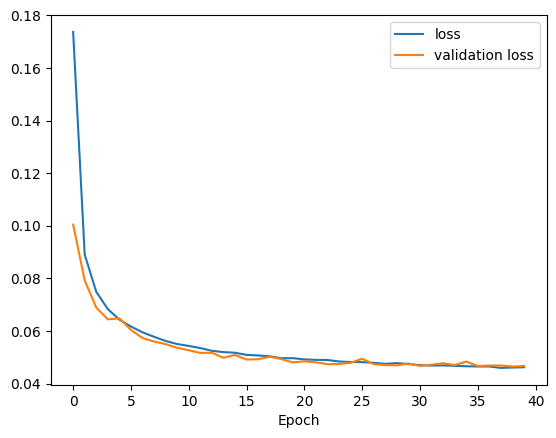

In [13]:
plot_loss(history)

This shows that for these settings the models improves quickly, showing overfitting. If we put the clean guitar signal through the model, we get back the effected signal. Now we dump this to disk:

In [14]:
trained_entire_clip = model.predict(np.resize(original_chunked, (original_chunked.size // chunk_size, chunk_size, 1)))
dump_numpy_audio(resize_to_mono(trained_entire_clip),
                 reference_wav='data/clean_guitar.wav',
                 output_wav='data/trained_distortion_guitar.wav')
wav_player('data/trained_distortion_guitar.wav')

44/44 [==============================] - 0s 2ms/step


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

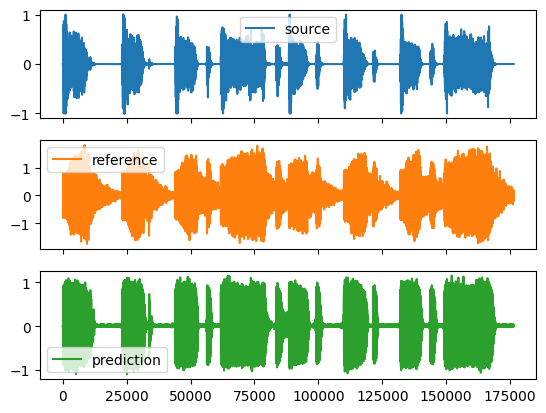

In [15]:
trained_flat = trained_entire_clip.flatten()
pd.DataFrame({'source': dist['original'][0:len(trained_flat)], 
              'reference': dist['effected'][0:len(trained_flat)], 
              'prediction': trained_flat}).plot(subplots=True)

<AxesSubplot:>

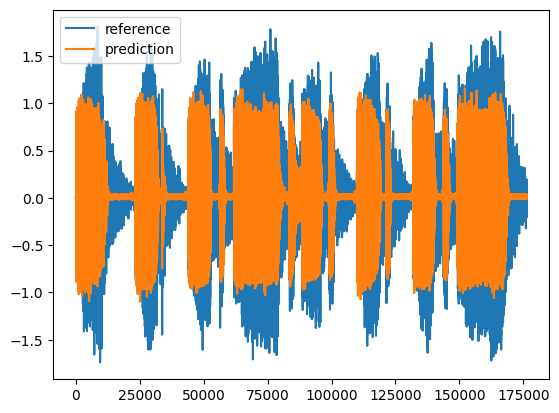

In [16]:
pd.DataFrame({'reference': dist['effected'][0:len(trained_flat)], 
              'prediction': trained_flat}).plot()

The audio and the plot clearly show the system has worked. However, you can clearly hear that the distortion effected is there, but the reverb is not. The last figure nicely illustrates this as the trailing reverb signals are not present in the prediction. 

This is explained by the fact that the CNN1d has a rather small kernel of size 3, making it hard to include non-local effects. In addition, the data is subdivided into chunks of data which limit the temporal relationships possible. 